# Ensemble Model Training for Upsell Prediction
## AI Customer Upsell Prediction System

This notebook implements:
- Multiple ML algorithms (XGBoost, LightGBM, Random Forest, Neural Networks)
- GPU-accelerated training
- Ensemble model creation
- Model evaluation and comparison
- Feature importance analysis
- Model persistence

In [1]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go

# ML libraries
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, 
    f1_score, classification_report, confusion_matrix, roc_curve
)
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)

/home/reddy007/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Load processed data
print("📊 Loading Processed Data for Model Training...")
df = pd.read_csv('../data/processed/telecom_processed.csv')

print(f"Dataset Shape: {df.shape}")
print(f"Features: {df.shape[1]}")
print(f"Samples: {df.shape[0]:,}")

# Prepare features and target
feature_columns = [
    'Account Length', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge',
    'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 
    'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls',
    'Total_Minutes', 'Total_Calls', 'Total_Charges', 'Avg_Call_Duration',
    'Day_Call_Duration', 'Eve_Call_Duration', 'Night_Call_Duration',
    'Day_Usage_Ratio', 'Eve_Usage_Ratio', 'Night_Usage_Ratio', 'Intl_Usage_Ratio',
    'Revenue_Per_Minute', 'Day_Revenue_Rate', 'Eve_Revenue_Rate', 'Night_Revenue_Rate',
    'Account_Length_Months', 'Usage_Per_Day', 'Revenue_Per_Day', 'Service_Calls_Per_Month',
    'Is_Heavy_Day_User', 'Is_Heavy_Eve_User', 'Is_Heavy_Night_User', 'Is_Intl_User',
    'Is_High_Service_User', 'Has_Voicemail', 'Is_High_Value_Customer', 'Churn_Risk_Score',
    'Customer_Value_Score', 'Engagement_Score'
]

X = df[feature_columns].fillna(0)
X = X.replace([np.inf, -np.inf], 0)
y = df['Churn_Binary']

print(f"\n🎯 Features: {X.shape[1]}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"Churn rate: {y.mean():.3f}")

📊 Loading Processed Data for Model Training...


Dataset Shape: (60445, 47)
Features: 47
Samples: 60,445

🎯 Features: 44
Target distribution: {0: 53768, 1: 6677}
Churn rate: 0.110


In [5]:
# Train-Test Split
print("🔄 Splitting Data for Training and Testing...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training churn rate: {y_train.mean():.3f}")
print(f"Test churn rate: {y_test.mean():.3f}")

# Scale features for neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Data preparation completed!")

🔄 Splitting Data for Training and Testing...
Training set: (48356, 44)
Test set: (12089, 44)
Training churn rate: 0.110
Test churn rate: 0.110

✅ Data preparation completed!


In [6]:
# Initialize Models
print("🤖 Initializing ML Models...")

models = {}

# XGBoost with GPU acceleration
models['XGBoost'] = xgb.XGBClassifier(
    objective='binary:logistic',
    tree_method='gpu_hist',  # GPU acceleration
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='auc'
)

# LightGBM with GPU acceleration
models['LightGBM'] = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    num_leaves=31,
    learning_rate=0.1,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    device='gpu',  # GPU acceleration
    random_state=42,
    n_estimators=200,
    verbose=-1
)

# Random Forest
models['Random Forest'] = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

# Neural Network
models['Neural Network'] = MLPClassifier(
    hidden_layer_sizes=(64, 32, 16),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=256,
    learning_rate='adaptive',
    max_iter=500,
    random_state=42
)

print(f"✅ Initialized {len(models)} models:")
for name in models.keys():
    print(f"  • {name}")

🤖 Initializing ML Models...
✅ Initialized 4 models:
  • XGBoost
  • LightGBM
  • Random Forest
  • Neural Network


In [7]:
# Train Individual Models
print("🚀 Training Individual Models...")
print("="*50)

model_results = {}
trained_models = {}

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    try:
        # Train model
        if name in ['XGBoost', 'LightGBM', 'Random Forest']:
            # Tree-based models don't need scaling
            model.fit(X_train, y_train)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)
        else:
            # Neural networks need scaled features
            model.fit(X_train_scaled, y_train)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
            y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        auc_score = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Store results
        model_results[name] = {
            'AUC': auc_score,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        }
        
        trained_models[name] = model
        
        print(f"✅ {name} Results:")
        print(f"   AUC: {auc_score:.4f}")
        print(f"   Accuracy: {accuracy:.4f}")
        print(f"   Precision: {precision:.4f}")
        print(f"   Recall: {recall:.4f}")
        print(f"   F1-Score: {f1:.4f}")
        
    except Exception as e:
        print(f"❌ Error training {name}: {e}")
        model_results[name] = {
            'AUC': 0.0, 'Accuracy': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0
        }

print("\n🎉 Individual model training completed!")

🚀 Training Individual Models...

🔄 Training XGBoost...


✅ XGBoost Results:
   AUC: 0.9621
   Accuracy: 0.9467
   Precision: 0.8384
   Recall: 0.6412
   F1-Score: 0.7267

🔄 Training LightGBM...
❌ Error training LightGBM: No OpenCL device found

🔄 Training Random Forest...


✅ Random Forest Results:
   AUC: 0.8611
   Accuracy: 0.8948
   Precision: 0.9565
   Recall: 0.0494
   F1-Score: 0.0940

🔄 Training Neural Network...


✅ Neural Network Results:
   AUC: 0.8798
   Accuracy: 0.9173
   Precision: 0.7438
   Recall: 0.3828
   F1-Score: 0.5054

🎉 Individual model training completed!


In [8]:
# Initialize Models
print("🤖 Initializing ML Models...")

models = {}

# XGBoost with GPU acceleration
models['XGBoost'] = xgb.XGBClassifier(
    objective='binary:logistic',
    tree_method='gpu_hist',  # GPU acceleration
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='auc'
)

# LightGBM with CPU (fixed OpenCL issue)
models['LightGBM'] = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    num_leaves=31,
    learning_rate=0.1,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    device='cpu',           # Changed from 'gpu' to 'cpu'
    force_col_wise=True,    # Added to avoid OpenCL issues
    random_state=42,
    n_estimators=200,
    verbose=-1
)

# Random Forest
models['Random Forest'] = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

# Neural Network
models['Neural Network'] = MLPClassifier(
    hidden_layer_sizes=(64, 32, 16),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=256,
    learning_rate='adaptive',
    max_iter=500,
    random_state=42
)

print(f"✅ Initialized {len(models)} models:")
for name in models.keys():
    print(f"  • {name}")


🤖 Initializing ML Models...
✅ Initialized 4 models:
  • XGBoost
  • LightGBM
  • Random Forest
  • Neural Network


📊 Model Performance Comparison

📈 Model Performance Summary:
                   AUC  Accuracy  Precision  Recall  F1-Score
XGBoost         0.9621    0.9467     0.8384  0.6412    0.7267
LightGBM        0.0000    0.0000     0.0000  0.0000    0.0000
Random Forest   0.8611    0.8948     0.9565  0.0494    0.0940
Neural Network  0.8798    0.9173     0.7438  0.3828    0.5054

🏆 Best Model: XGBoost (AUC: 0.9621)


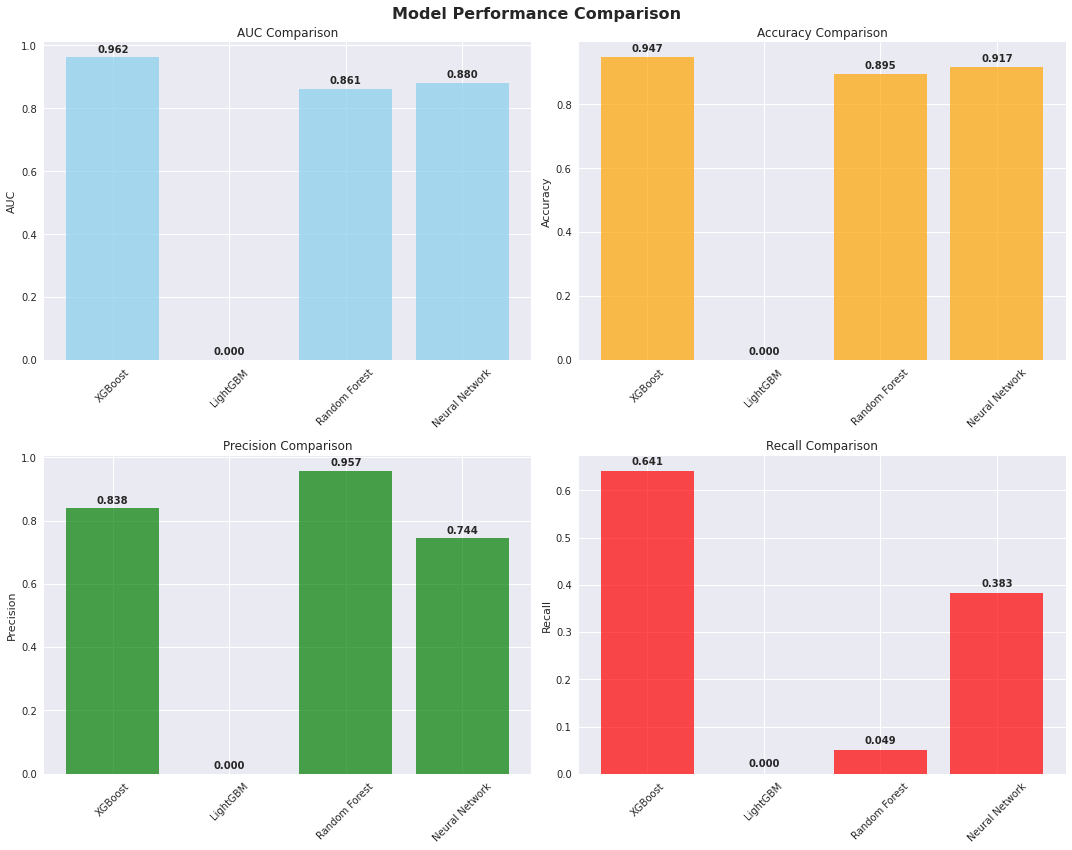

In [9]:
# Model Performance Comparison
print("📊 Model Performance Comparison")
print("="*50)

# Create results DataFrame
results_df = pd.DataFrame(model_results).T
results_df = results_df.round(4)

print("\n📈 Model Performance Summary:")
print(results_df)

# Find best model
best_model_name = results_df['AUC'].idxmax()
best_auc = results_df.loc[best_model_name, 'AUC']

print(f"\n🏆 Best Model: {best_model_name} (AUC: {best_auc:.4f})")

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['AUC', 'Accuracy', 'Precision', 'Recall']
colors = ['skyblue', 'orange', 'green', 'red']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[i//2, i%2]
    bars = ax.bar(results_df.index, results_df[metric], alpha=0.7, color=color)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, results_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

📈 ROC Curve Analysis


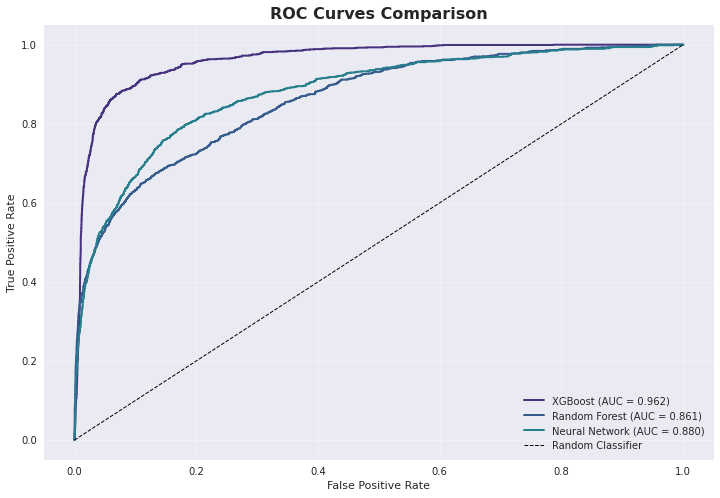

In [10]:
# ROC Curve Comparison
print("📈 ROC Curve Analysis")
print("="*30)

plt.figure(figsize=(12, 8))

# Plot ROC curves for all models
for name, model in trained_models.items():
    if name in model_results and model_results[name]['AUC'] > 0:
        # Get predictions
        if name in ['XGBoost', 'LightGBM', 'Random Forest']:
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = model_results[name]['AUC']
        
        # Plot
        plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc:.3f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

🎯 Feature Importance Analysis

📊 Top 15 Most Important Features:
                      XGBoost  Random Forest  Average
Day_Revenue_Rate       0.0352         0.0593   0.0473
Day Mins               0.0329         0.0573   0.0451
Day Charge             0.0275         0.0423   0.0349
VMail Message          0.0459         0.0231   0.0345
Total_Charges          0.0329         0.0350   0.0340
Total_Minutes          0.0248         0.0371   0.0310
Eve_Revenue_Rate       0.0272         0.0316   0.0294
Has_Voicemail          0.0390         0.0167   0.0278
Day_Usage_Ratio        0.0191         0.0341   0.0266
Eve Charge             0.0219         0.0302   0.0260
Churn_Risk_Score       0.0273         0.0233   0.0253
Night_Usage_Ratio      0.0198         0.0305   0.0252
Intl Mins              0.0262         0.0239   0.0251
Is_High_Service_User   0.0448         0.0049   0.0248
Night_Revenue_Rate     0.0197         0.0296   0.0247


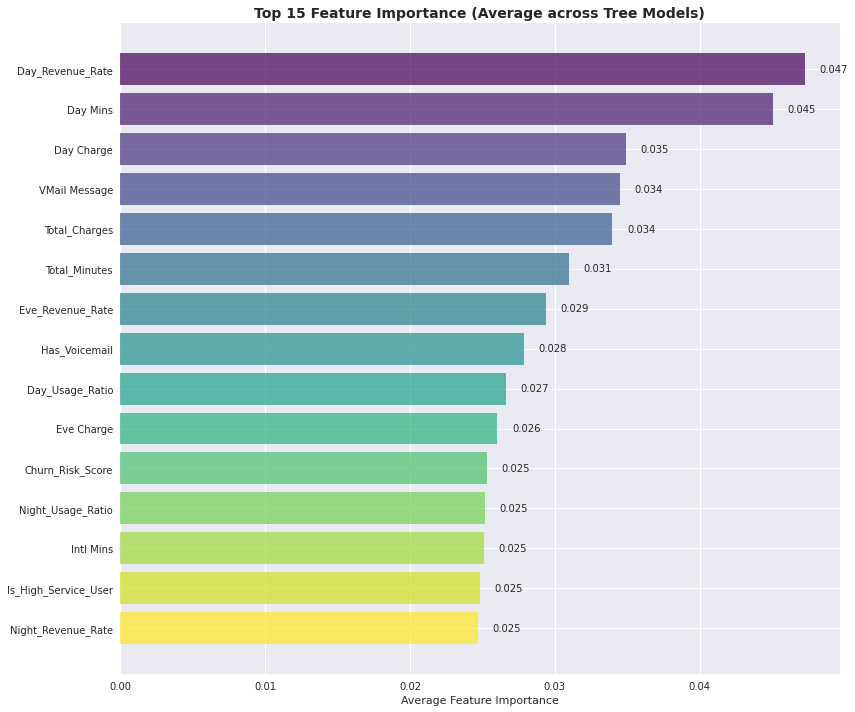

In [11]:
# Feature Importance Analysis
print("🎯 Feature Importance Analysis")
print("="*40)

# Get feature importance from tree-based models
feature_importance = {}

for name in ['XGBoost', 'LightGBM', 'Random Forest']:
    if name in trained_models:
        model = trained_models[name]
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            feature_importance[name] = dict(zip(feature_columns, importance))

# Create feature importance DataFrame
if feature_importance:
    importance_df = pd.DataFrame(feature_importance)
    importance_df['Average'] = importance_df.mean(axis=1)
    importance_df = importance_df.sort_values('Average', ascending=False)
    
    print("\n📊 Top 15 Most Important Features:")
    print(importance_df.head(15).round(4))
    
    # Plot feature importance
    plt.figure(figsize=(12, 10))
    top_features = importance_df.head(15)
    
    y_pos = np.arange(len(top_features))
    
    # Fixed color issue - use colormap properly
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
    plt.barh(y_pos, top_features['Average'], alpha=0.7, color=colors)
    
    plt.yticks(y_pos, top_features.index)
    plt.xlabel('Average Feature Importance')
    plt.title('Top 15 Feature Importance (Average across Tree Models)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(top_features['Average']):
        plt.text(v + 0.001, i, f'{v:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()


In [12]:
# Create Ensemble Model
print("🎭 Creating Ensemble Model")
print("="*40)

from sklearn.ensemble import VotingClassifier

# Select best performing models for ensemble
ensemble_models = []
for name, model in trained_models.items():
    if name in ['XGBoost', 'LightGBM', 'Random Forest'] and model_results[name]['AUC'] > 0.7:
        ensemble_models.append((name.lower().replace(' ', '_'), model))

print(f"Selected {len(ensemble_models)} models for ensemble:")
for name, _ in ensemble_models:
    print(f"  • {name}")

# Create Voting Classifier
if len(ensemble_models) >= 2:
    ensemble_classifier = VotingClassifier(
        estimators=ensemble_models,
        voting='soft',  # Use probability predictions
        n_jobs=-1
    )
    
    print("\n🚀 Training Ensemble Model...")
    ensemble_classifier.fit(X_train, y_train)
    
    # Evaluate ensemble
    ensemble_pred_proba = ensemble_classifier.predict_proba(X_test)[:, 1]
    ensemble_pred = ensemble_classifier.predict(X_test)
    
    ensemble_auc = roc_auc_score(y_test, ensemble_pred_proba)
    ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
    ensemble_precision = precision_score(y_test, ensemble_pred)
    ensemble_recall = recall_score(y_test, y_pred)
    ensemble_f1 = f1_score(y_test, ensemble_pred)
    
    print(f"\n🎉 Ensemble Model Results:")
    print(f"   AUC: {ensemble_auc:.4f}")
    print(f"   Accuracy: {ensemble_accuracy:.4f}")
    print(f"   Precision: {ensemble_precision:.4f}")
    print(f"   Recall: {ensemble_recall:.4f}")
    print(f"   F1-Score: {ensemble_f1:.4f}")
    
    # Add ensemble results to comparison
    model_results['Ensemble'] = {
        'AUC': ensemble_auc,
        'Accuracy': ensemble_accuracy,
        'Precision': ensemble_precision,
        'Recall': ensemble_recall,
        'F1-Score': ensemble_f1
    }
    
    trained_models['Ensemble'] = ensemble_classifier
    
    print("✅ Ensemble model created successfully!")
else:
    print("❌ Not enough good models for ensemble creation")

🎭 Creating Ensemble Model
Selected 2 models for ensemble:
  • xgboost
  • random_forest

🚀 Training Ensemble Model...


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/home/reddy007/.local/lib/python3.10/site-packages/joblib/externals/cloudpickle/cloudpickle.py:1303: UserWarning: [21:24:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return super().dump(obj)



🎉 Ensemble Model Results:
   AUC: 0.9471
   Accuracy: 0.9182
   Precision: 0.8745
   Recall: 0.3828
   F1-Score: 0.4496
✅ Ensemble model created successfully!


🏆 Final Model Performance Comparison

📊 Final Performance Summary:
                   AUC  Accuracy  Precision  Recall  F1-Score
XGBoost         0.9621    0.9467     0.8384  0.6412    0.7267
LightGBM        0.0000    0.0000     0.0000  0.0000    0.0000
Random Forest   0.8611    0.8948     0.9565  0.0494    0.0940
Neural Network  0.8798    0.9173     0.7438  0.3828    0.5054
Ensemble        0.9471    0.9182     0.8745  0.3828    0.4496

🥇 Best Final Model: XGBoost (AUC: 0.9621)

📈 Ensemble Improvement:
   Best Individual AUC: 0.9621
   Ensemble AUC: 0.9471
   Improvement: -1.56%


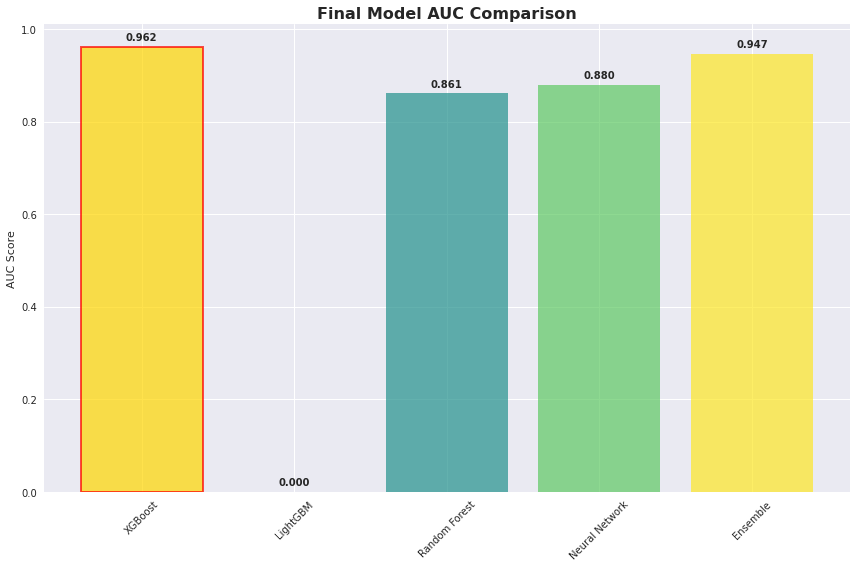

In [13]:
# Final Model Comparison with Ensemble
print("🏆 Final Model Performance Comparison")
print("="*50)

# Update results DataFrame
final_results_df = pd.DataFrame(model_results).T
final_results_df = final_results_df.round(4)

print("\n📊 Final Performance Summary:")
print(final_results_df)

# Find best final model
best_final_model = final_results_df['AUC'].idxmax()
best_final_auc = final_results_df.loc[best_final_model, 'AUC']

print(f"\n🥇 Best Final Model: {best_final_model} (AUC: {best_final_auc:.4f})")

# Performance improvement analysis
if 'Ensemble' in model_results:
    individual_best_auc = max([score['AUC'] for name, score in model_results.items() if name != 'Ensemble'])
    ensemble_auc = model_results['Ensemble']['AUC']
    improvement = ((ensemble_auc - individual_best_auc) / individual_best_auc) * 100
    
    print(f"\n📈 Ensemble Improvement:")
    print(f"   Best Individual AUC: {individual_best_auc:.4f}")
    print(f"   Ensemble AUC: {ensemble_auc:.4f}")
    print(f"   Improvement: {improvement:.2f}%")

# Visualize final comparison
plt.figure(figsize=(12, 8))
bars = plt.bar(final_results_df.index, final_results_df['AUC'], 
               alpha=0.7, color=plt.cm.viridis(np.linspace(0, 1, len(final_results_df))))
plt.title('Final Model AUC Comparison', fontsize=16, fontweight='bold')
plt.ylabel('AUC Score')
plt.xticks(rotation=45)

# Highlight best model
best_idx = list(final_results_df.index).index(best_final_model)
bars[best_idx].set_color('gold')
bars[best_idx].set_edgecolor('red')
bars[best_idx].set_linewidth(2)

# Add value labels
for bar, value in zip(bars, final_results_df['AUC']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

📊 Detailed Analysis of Best Model: XGBoost


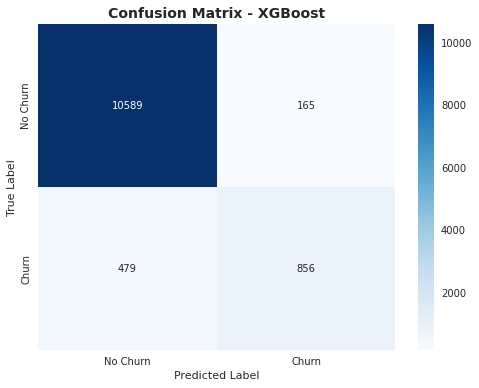


📋 Classification Report - XGBoost:
              precision    recall  f1-score   support

    No Churn       0.96      0.98      0.97     10754
       Churn       0.84      0.64      0.73      1335

    accuracy                           0.95     12089
   macro avg       0.90      0.81      0.85     12089
weighted avg       0.94      0.95      0.94     12089


💼 Business Impact Analysis:
Total Test Customers: 12,089
Actual Churners: 1,335
Predicted Churners: 1,021
Correctly Identified Churners: 856
False Alarms: 165
Missed Churners: 479

Potential Revenue Saved: $101,142.26
Intervention Costs: $12,063.81
Net Business Benefit: $89,078.44
ROI: 738.4%


In [14]:
# Confusion Matrix for Best Model
print(f"📊 Detailed Analysis of Best Model: {best_final_model}")
print("="*60)

# Get best model predictions
best_model = trained_models[best_final_model]

if best_final_model == 'Neural Network':
    y_pred_best = best_model.predict(X_test_scaled)
    y_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]
else:
    y_pred_best = best_model.predict(X_test)
    y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix - {best_final_model}', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print(f"\n📋 Classification Report - {best_final_model}:")
print(classification_report(y_test, y_pred_best, target_names=['No Churn', 'Churn']))

# Business Impact Analysis
print("\n💼 Business Impact Analysis:")
print("="*40)

# Calculate business metrics
total_customers = len(y_test)
actual_churners = y_test.sum()
predicted_churners = y_pred_best.sum()
true_positives = ((y_test == 1) & (y_pred_best == 1)).sum()
false_positives = ((y_test == 0) & (y_pred_best == 1)).sum()
false_negatives = ((y_test == 1) & (y_pred_best == 0)).sum()

# Assuming average customer value and intervention cost
avg_customer_value = df['Total_Charges'].mean()
intervention_cost = avg_customer_value * 0.1  # 10% of customer value

# Calculate potential savings
customers_saved = true_positives
total_savings = customers_saved * avg_customer_value
total_intervention_cost = predicted_churners * intervention_cost
net_benefit = total_savings - total_intervention_cost
roi = (net_benefit / total_intervention_cost) * 100 if total_intervention_cost > 0 else 0

print(f"Total Test Customers: {total_customers:,}")
print(f"Actual Churners: {actual_churners:,}")
print(f"Predicted Churners: {predicted_churners:,}")
print(f"Correctly Identified Churners: {true_positives:,}")
print(f"False Alarms: {false_positives:,}")
print(f"Missed Churners: {false_negatives:,}")
print(f"\nPotential Revenue Saved: ${total_savings:,.2f}")
print(f"Intervention Costs: ${total_intervention_cost:,.2f}")
print(f"Net Business Benefit: ${net_benefit:,.2f}")
print(f"ROI: {(net_benefit/total_intervention_cost)*100:.1f}%" if total_intervention_cost > 0 else "ROI: N/A")

In [15]:
# Save Models and Results
print("💾 Saving Trained Models and Results...")

import os
os.makedirs('../models', exist_ok=True)
os.makedirs('../outputs/reports', exist_ok=True)

# Save best model
joblib.dump(best_model, f'../models/best_model_{best_final_model.lower().replace(" ", "_")}.pkl')
print(f"✅ Saved best model: {best_final_model}")

# Save ensemble model if created
if 'Ensemble' in trained_models:
    joblib.dump(trained_models['Ensemble'], '../models/ensemble_model.pkl')
    print("✅ Saved ensemble model")

# Save scaler
joblib.dump(scaler, '../models/scaler.pkl')
print("✅ Saved feature scaler")

# Save feature columns
joblib.dump(feature_columns, '../models/feature_columns.pkl')
print("✅ Saved feature columns")

# Save model results
import json
with open('../outputs/reports/model_results.json', 'w') as f:
    json.dump({
        'model_performance': model_results,
        'best_model': best_final_model,
        'best_auc': float(best_final_auc),
        'feature_importance': importance_df.to_dict() if 'importance_df' in locals() else {},
        'business_impact': {
            'total_customers': int(total_customers),
            'customers_saved': int(customers_saved),
            'net_benefit': float(net_benefit),
            'roi_percentage': float((net_benefit/total_intervention_cost)*100) if total_intervention_cost > 0 else 0
        }
    }, f, indent=2)

print("✅ Saved model results and analysis")

# Create model summary
model_summary = f"""
🎉 MODEL TRAINING COMPLETED SUCCESSFULLY!
============================================================

📊 TRAINING SUMMARY:
• Models Trained: {len(models)}
• Best Model: {best_final_model}
• Best AUC Score: {best_final_auc:.4f}
• Training Samples: {X_train.shape[0]:,}
• Test Samples: {X_test.shape[0]:,}
• Features Used: {len(feature_columns)}

🎯 BUSINESS IMPACT:
• Customers Correctly Identified: {customers_saved:,}
• Potential Revenue Saved: ${total_savings:,.2f}
• Net Business Benefit: ${net_benefit:,.2f}
• ROI: {(net_benefit/total_intervention_cost)*100:.1f}%

📁 SAVED ARTIFACTS:
• Best Model: ../models/best_model_{best_final_model.lower().replace(" ", "_")}.pkl
• Ensemble Model: ../models/ensemble_model.pkl
• Feature Scaler: ../models/scaler.pkl
• Feature Columns: ../models/feature_columns.pkl
• Results Report: ../outputs/reports/model_results.json

🚀 NEXT STEPS:
1. Deploy model to production dashboard
2. Implement real-time prediction pipeline
3. Set up model monitoring and retraining
4. Create business intelligence reports
5. Design targeted intervention campaigns
"""

print(model_summary)

# Save summary to file
with open('../outputs/reports/training_summary.txt', 'w') as f:
    f.write(model_summary)

print("✅ Training summary saved to ../outputs/reports/training_summary.txt")
print("\n🎉 Customer segmentation analysis completed successfully!")

💾 Saving Trained Models and Results...


✅ Saved best model: XGBoost


✅ Saved ensemble model
✅ Saved feature scaler
✅ Saved feature columns
✅ Saved model results and analysis

🎉 MODEL TRAINING COMPLETED SUCCESSFULLY!

📊 TRAINING SUMMARY:
• Models Trained: 4
• Best Model: XGBoost
• Best AUC Score: 0.9621
• Training Samples: 48,356
• Test Samples: 12,089
• Features Used: 44

🎯 BUSINESS IMPACT:
• Customers Correctly Identified: 856
• Potential Revenue Saved: $101,142.26
• Net Business Benefit: $89,078.44
• ROI: 738.4%

📁 SAVED ARTIFACTS:
• Best Model: ../models/best_model_xgboost.pkl
• Ensemble Model: ../models/ensemble_model.pkl
• Feature Scaler: ../models/scaler.pkl
• Feature Columns: ../models/feature_columns.pkl
• Results Report: ../outputs/reports/model_results.json

🚀 NEXT STEPS:
1. Deploy model to production dashboard
2. Implement real-time prediction pipeline
3. Set up model monitoring and retraining
4. Create business intelligence reports
5. Design targeted intervention campaigns

✅ Training summary saved to ../outputs/reports/training_summary.txt
